In [1]:
import copy
import torch
import random
import argparse

import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from math import sqrt
from tqdm import tqdm

from utils import (
    generate_x,
    generate_y,
    conduct_gd,
    combine_input,
    
    SimpleAttn,
)


In [24]:
class SimpleAttn(nn.Module):
    def __init__(self, input_size, layer_num = 1, context_length = None, apply_cot_init = True):
        super(SimpleAttn, self).__init__()
        self.input_size = input_size
        self.context_length = context_length
        # initialize parameter
        self.w_ov = nn.Parameter(torch.randn(input_size,input_size)*0.002/layer_num) # input_size * (head_num * input_size)
        self.w_qk = nn.Parameter(torch.randn(input_size,input_size)*0.002/layer_num) # input_size * (head_num * input_size)
        
        # self.w_ov = nn.Parameter(torch.zeros(input_size,input_size*self.head_num)) # input_size * (head_num * input_size)
        # self.w_qk = nn.Parameter(torch.zeros(input_size,input_size*self.head_num)) # input_size * (head_num * input_size)
        # self.w_ov = nn.Parameter(torch.concat([torch.eye(input_size) for _ in range(self.head_num)], dim = -1))# input_size * (head_num * input_size)
        # self.w_qk = nn.Parameter(torch.concat([torch.eye(input_size) for _ in range(self.head_num)], dim = -1)) # input_size * (head_num * input_size)
        if apply_cot_init:
            self.cot_init()
        
    def cot_init(self):
        x_dim = self.input_size // 2 - 1
        self.w_ov.data.zero_()
        self.w_qk.data.zero_()
        
        w_ov_slice = self.w_ov[ : x_dim + 1,  x_dim + 1 :].detach()
        w_qk_slice = self.w_qk[x_dim + 1 :, : x_dim + 1].detach()
        
        w_ov_slice.copy_(torch.randn(x_dim + 1, x_dim + 1) * 0.002)
        w_qk_slice.copy_(torch.randn(x_dim + 1, x_dim + 1) * 0.002)
    
    def forward(self, input_seq, **kwargs):
        assert input_seq.dim() == 3 # b * t * c
        b,t,c = input_seq.size()
        Q = input_seq @ self.w_qk # b * t * c
        K = input_seq # b * t * c
        V = input_seq @ self.w_ov # b * t * c
        
        A = Q @ K.transpose(-1,-2) # A : b  * t * t
        if self.context_length is not None:
            A[:, self.context_length: , self.context_length :] = 0
        out = A @ V # b * t * c
        return out / self.context_length + input_seq # b * t * c
    def inference(self, input_seq, noise = 0, **kwargs):
        assert input_seq.dim() == 3 # b * t * c
        b,t,c = input_seq.size()
        Q = input_seq @ self.w_qk # b * t * c
        K = input_seq # b * t * c
        V = input_seq @ self.w_ov # b * t * c
        
        A = Q @ K.transpose(-1,-2) # A : b  * t * t
        if self.context_length is not None:
            A[:, self.context_length: , self.context_length :] = 0
        out = A @ V # b * t * c
        last_token = (out / self.context_length + input_seq)[:,-1,:]
        last_token += torch.randn(last_token.size(), device = device) * noise
        return last_token # b * 1 * c

device = "cuda:1"
x_dim       = 5
n_layer     = 1
head_num    = 1
batch_num   = 1024
data_range  = 1
example_num = 20

eta         = 0.4
cot_steps   = 10

model = SimpleAttn(
    input_size= 2 * (x_dim + 1),
    context_length=example_num
).to(device)

In [181]:
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
y_context, w_all = generate_y(x_all = x_context, weight_range = 1, noise = 0, device = device)
w_cot = conduct_gd(x_context, y_context, eta , w0 = None, steps = cot_steps)
input_seq = combine_input(x_context, y_context, w_cot)

  2%|▏         | 15/800 [00:00<00:05, 144.34it/s]

100%|██████████| 800/800 [00:02<00:00, 275.78it/s]


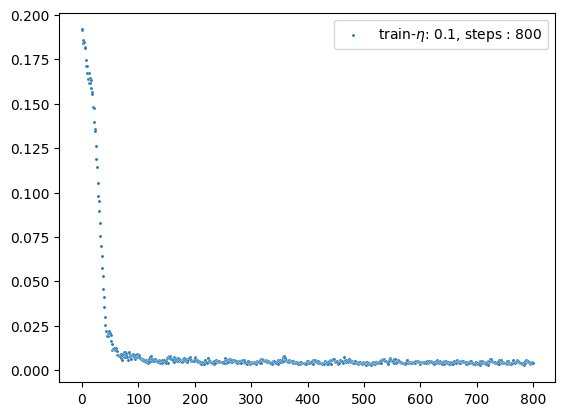

In [60]:
device      = "cuda:1"

x_dim       = 10
n_layer     = 1
head_num    = 1
batch_num   = 1024
data_range  = 1
example_num = 20

eta         = 0.1
cot_steps   = 10

model = SimpleAttn(
    input_size= 2 * (x_dim + 1),
    context_length=example_num
).to(device)

loss_fnc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
steps = 800

train_loss_all = []



def cal_loss(tf_out, input_seq, example_num):
    pre = tf_out[:,example_num:,:]
    tgt = input_seq[:,example_num + 1:,:]
    loss = (pre - tgt).norm(dim = -1).mean()
    return loss

for it in tqdm(range(steps)):
    optimizer.zero_grad()
    x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
    y_context, w_all = generate_y(x_all = x_context, weight_range = 1, noise = 0, device = device)
    w_cot = conduct_gd(x_context, y_context, eta , w0 = None, steps = cot_steps)
    input_seq = combine_input(x_context, y_context, w_cot)
    tf_out = model(input_seq[:,:-1,:])
    loss = cal_loss(tf_out, input_seq, example_num)
    train_loss_all += [loss.item()]
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    optimizer.zero_grad()

######################################
# visualzation
######################################

sns.scatterplot(x = np.arange(len(train_loss_all)), y = train_loss_all, label = f"train-$\\eta$: {eta}, steps : {steps}", s = 5)
plt.show()


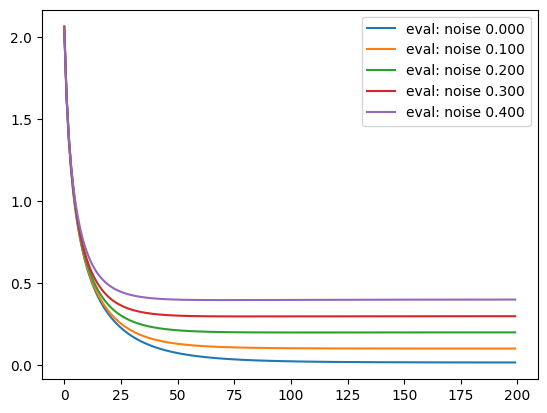

In [31]:
steps_inference = 200

for noise in [0,0.1,0.2,0.3,0.4]:
    loss_all = []
    with torch.no_grad():
        x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
        y_context, w_all = generate_y(x_all = x_context, weight_range = 1, noise = noise, device = device)
        w_cot = conduct_gd(x_context, y_context, eta , w0 = None, steps = 0)
        input_seq = combine_input(x_context, y_context, w_cot)
        for i in range(steps_inference):
            tf_out = model.inference(input_seq)
            pre = tf_out[:, x_dim + 1: 2 * x_dim + 1]
            loss = (pre - w_all).norm(dim = -1).mean().item()
            # print(f"{i}-{loss:.5f}")
            input_seq = torch.concat(
                [input_seq, tf_out[:,None,:]], dim = -2
            )
            loss_all += [loss]

    sns.lineplot(x = np.arange(len(loss_all)), y = loss_all, label = f"eval: noise {noise:.3f}")
plt.show()

In [27]:
tf_out[:,None,:].size()

torch.Size([1024, 1, 22])

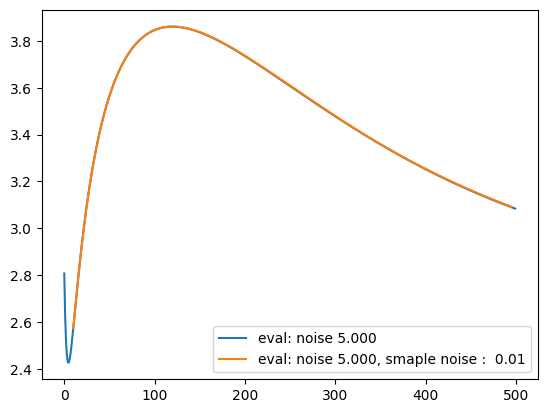

In [76]:
def agg_data(save_datas, idx):
    agg_datas = [d[idx] for d in save_datas]
    agg_datas = sum(agg_datas) / len(agg_datas)
    return agg_datas

steps_all = 500
sample_num = 100
noise = 5
sample_noise = 1e-2
save_datas = []
plot_steps = np.arange(10,steps_all,5)
with torch.no_grad():
    loss_all = []
    x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
    y_context, w_all = generate_y(x_all = x_context, weight_range = 1, noise = noise, device = device)
    w_cot = conduct_gd(x_context, y_context, eta , w0 = None, steps = 0)
    input_seq = combine_input(x_context, y_context, w_cot)
    for i in range(steps_all):
        tf_out = model.inference(input_seq, noise = 0)
        pre = tf_out[:, x_dim + 1: 2 * x_dim + 1]
        loss = (pre - w_all).norm(dim = -1).mean().item()
        # raise
        # print(f"{i}-{loss:.5f}")
        input_seq = torch.concat(
            [input_seq, tf_out[:,None,:]], dim = -2
        )
        loss_all += [loss]
    for _ in range(sample_num):
        save_data = []
        input_seq = combine_input(x_context, y_context, w_cot)
        for i in range(steps_all):
            tf_out = model.inference(input_seq, noise = sample_noise)
            pre = tf_out[:, x_dim + 1: 2 * x_dim + 1]
            input_seq = torch.concat(
                [input_seq, tf_out[:,None,:]], dim = -2
            )
            if i in plot_steps:
                save_data += [pre.clone()]
        save_datas += [save_data]

    plot_loss = []
    for idx, plot_step in enumerate(plot_steps):
        agg_datas = agg_data(save_datas, idx)
        loss = (agg_datas - w_all).norm(dim = -1).mean().item()
        plot_loss += [loss]
sns.lineplot(x = np.arange(len(loss_all)), y = loss_all, label = f"eval: noise {noise:.3f}")
sns.lineplot(x = plot_steps, y = plot_loss, label = f"eval: noise {noise:.3f}, smaple noise :  {sample_noise}")
plt.show()

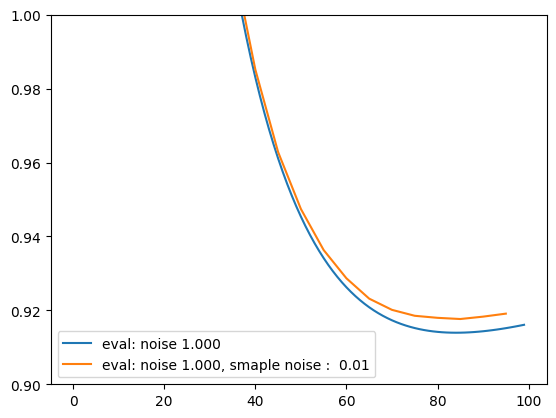

In [68]:
sns.lineplot(x = np.arange(len(loss_all)), y = loss_all, label = f"eval: noise {noise:.3f}")
sns.lineplot(x = plot_steps, y = plot_loss, label = f"eval: noise {noise:.3f}, smaple noise :  {sample_noise}")
plt.ylim(0.9,1)
plt.show()

In [36]:
len(loss_all)

1943